In [53]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 280)

football_feed_df = pd.read_csv('football_feed_df.csv')
print(football_feed_df.columns)
football_feed_df.head()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang',
       'team', 'user_id', 'possibly_sensitive', 'retweeted_status_id',
       'extended_entities', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status', 'hashtags', 'user_mentions', 'emoji', 'processed_text',
       'full_text', 'display_text_range'],
      dtype='object')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,team,user_id,possibly_sensitive,retweeted_status_id,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,hashtags,user_mentions,emoji,processed_text,full_text,display_text_range
0,0,0,0,0.0,Thu Nov 12 20:34:18 +0000 2020,1326986703228186624,1326986703228186624,Enter for your chance to win a Packers Salute to Service prize package!,False,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,False,False,en,Packers,227741667,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],Enter chance win Packers Salute Service prize package !,Enter for your chance to win a Packers Salute to Service prize package!,NaN
1,1,1,1,1.0,Thu Nov 12 20:34:05 +0000 2020,1326986645300801541,1326986645300801541,.meets with the media on Thursday as the #Packers prepare for the Jaguars 🎥,False,"{'hashtags': [{'text': 'Packers', 'indices': [68, 76]}], 'symbols': [], 'user_mentions': [{'screen_name': 'packers', 'name': 'Green Bay Packers', 'id': 35865630, 'id_str': '35865630', 'indices': [3, 11]}, {'screen_name': '_SmashAmos31', 'name': 'Adrian Amos', 'id': 248086619,...","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,6,0,False,False,en,Packers,1326876581147660289,False,1.326984e+18,NaN,NaN,NaN,NaN,"[{'text': 'Packers', 'indices': [68, 76]}]",Green Bay Packers,"[('🎥', ':movie_camera:')]",.meets medium Thursday # Packers prepare Jaguars 🎥,.meets with the media on Thursday as the #Packers prepare for the Jaguars 🎥,NaN
2,2,2,2,2.0,Thu Nov 12 20:33:50 +0000 2020,1326986583216697346,1326986583216697346,over 27-25\r\nover 36-32\r\nover 21-17\r\nover…,True,"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Colts', 'name': 'Indianapolis Colts', 'id': 180884045, 'id_str': '180884045', 'indices': [0, 6]}, {'screen_name': 'Titans', 'name': 'Tennessee Titans', 'id': 19383279, 'id_str': '19383279', 'indices': [12, 19]...","{'iso_language_code': 'nl', 'result_type': 'recent'}","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",NaN,NaN,180884045.0,180884045.0,Colts,NaN,NaN,NaN,NaN,False,0,0,False,False,nl,Packers,1179783713342623744,NaN,NaN,NaN,NaN,NaN,NaN,[],Indianapolis Colts,[],27-25 36-32 21-17 over…,over 27-25\r\nover 36-32\r\nover 21-17\r\nover…,NaN
3,3,3,3,3.0,Thu Nov 12 20:33:38 +0000 2020,1326986533161873415,1326986533161873415,colts d or packers d,False,"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': '1_and_only_arod', 'name': 'AR 🇩🇴', 'id': 818010236, 'id_str': '818010236', 'indices': [0, 16]}], 'urls': []}","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,818010236.0,818010236.0,1_and_only_arod,NaN,NaN,NaN,NaN,False,0,0,False,False,en,Packers,2152753409,NaN,NaN,NaN,NaN,NaN,NaN,[],AR 🇩🇴,[],colt packer,colts d or packers d,NaN
4,4,4,4,4.0,Thu Nov 12 20:33:25 +0000 2020,1326986479667716102,1326986479667716102,"“Everyone knows he’s going to get the ball,” Jaguars coach Doug Marrone said in a conference call on Wednesday. “Yo…",True,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/lZ0aXbuSvn', 'expanded_url': 'https://twitter.com/i/web/status/1326986479667716102', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}","{'iso_language_code': 'en', 'result_type': 'recent'}","<a href

In [55]:
#check to see how many repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

4023
4023


In [56]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)
football_feed_df['team']= football_feed_df['team'].str.replace('DaBears', 'Bears')
football_feed_df['team'] = football_feed_df['team'].str.replace('ChiefsKingdom', 'Chiefs')

In [57]:
#check to make sure the number of tweets per team remains similar 
football_feed_df['team'].value_counts()

Packers    730
Cowboys    714
Eagles     697
Chiefs     648
Bears      629
Raiders    605
Name: team, dtype: int64

In [58]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [59]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [60]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent

In [61]:
football_feed_df["full_text"] = football_feed_df["full_text"].apply(str)
clean_football_tweets = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df['tokens'] = football_feed_df["full_text"].apply(clean_tweet)

clean_football_tweets[0:3]

0    [Enter, chance, win, Packers, Salute, Service, prize, package]
1               [meets, media, Thursday, Packers, prepare, Jaguars]
2                                          [27, 25, 36, 32, 21, 17]
Name: full_text, dtype: object

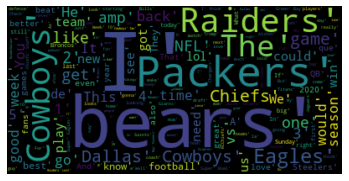

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, clean_football_tweets))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


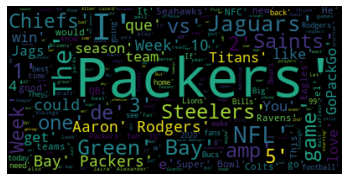

Bears


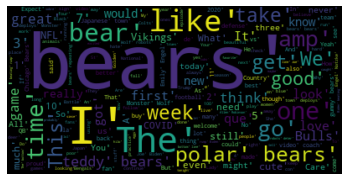

Eagles


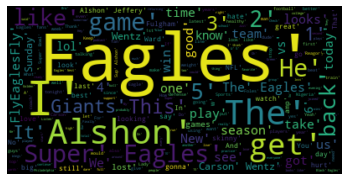

Cowboys


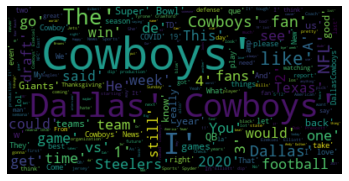

Raiders


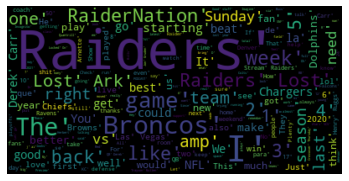

Chiefs


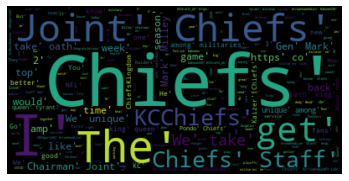

In [63]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()

# Some Legit Ass NLP

In [64]:
from nltk.corpus import twitter_samples

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
        
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [65]:
clean_positive = pd.Series(positive_tweets).apply(clean_tweet)
clean_negative = pd.Series(negative_tweets).apply(clean_tweet)

clean_positive = get_tweets_for_model(clean_positive)
clean_negative = get_tweets_for_model(clean_negative)


In [66]:
positive_dataset = [(tweet_dict, 1)
                     for tweet_dict in clean_positive]

negative_dataset = [(tweet_dict, 0)
                     for tweet_dict in clean_negative]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]


In [67]:

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = nltk.NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

#print(classifier.show_most_informative_features(10))


Accuracy is: 0.7773333333333333


In [68]:
football_clean = get_tweets_for_model(clean_football_tweets)

football_dat = [(tweet_dict)
                     for tweet_dict in football_clean]

In [69]:
classifier.classify(football_dat[0])

#Classify each tweet one by one (not a vectorized process)
sentiment = []
for tweet in football_dat:
    s = classifier.classify(tweet)
    sentiment.append(s)

football_feed_df['sentiment'] = sentiment

In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

football_feed_df[['full_text', 'sentiment']]



,full_text,sentiment
0,Enter for your chance to win a Packers Salute to Service prize package!,0
1,.meets with the media on Thursday as the #Packers prepare for the Jaguars 🎥,1
2,over 27-25\r\nover 36-32\r\nover 21-17\r\nover…,1
3,colts d or packers d,0
4,"“Everyone knows he’s going to get the ball,” Jaguars coach Doug Marrone said in a conference call on Wednesday. “Yo…",1
...,...,...
4018,Dallas Cowboys/LA Lakers,0
4019,How many overall picks will the Dallas Cowboys own in the 2021 NFL draft?\n\n| #CowboysNation,0
4020,How many overall picks will the Dallas Cowboys own in the 2021 NFL draft?\n\n| #CowboysNation,0
4021,This player has really turned things around for the #DallasCowboys,0


## read in journalism scrape

In [71]:
football_articles = pd.read_csv('sports_journalism.csv') #row 15 has text NAN
football_articles.isna().sum()

football_articles.dropna(subset=['Text'], inplace=True)
football_articles.isna().sum()#make sure there are no nans in txt or team 

football_articles['Team'].value_counts() #make sure team counts roughly even 

chiefs     117
bears      105
packers    100
eagles      95
cowboys     87
raiders     59
Name: Team, dtype: int64

In [72]:
#preprocess article text
article_tokens = football_articles["Text"].apply(clean_tweet)
clean_article = get_tweets_for_model(article_tokens)

article_dat = [(art_dict)
                     for art_dict in clean_article]
#article_dat[0:3]

In [73]:
sentiment = []
for a in article_dat:
    s = classifier.classify(a)
    sentiment.append(s)

football_articles['sentiment'] = sentiment

In [74]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 50)

football_articles[['Text', 'sentiment']]

,Text,sentiment
0,Chiefs coach Andy Reid addresses the Raiders' ...,0
1,Patrick Mahomes is announced as a member of th...,1
2,Chicago native Michael Wilbon says Theo Epstei...,1
3,"GREEN BAY, Wis. -- It's not Marquez Valdes-Sca...",0
4,"FRISCO, Texas -- As the country experiences a ...",0
...,...,...
559,Just as we thought the Kansas City Chiefs were...,1
560,Tucker D. FranklinWhile there are many Kansas ...,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,1


In [75]:
##combine the sources 
football_feed_df['source'] = ['Twitter' for r in range(len(football_feed_df))]
football_articles['source'] = ['Web Article' for r in range(len(football_articles))]

football_articles.rename(columns={'Team': 'team', 'Text': 'full_text'}, inplace=True)
football_articles['team'] = football_articles['team'].str.capitalize()
total_df = pd.concat([football_feed_df[['full_text', 'team', 'source', 'sentiment']], football_articles[['full_text', 'team', 'source', 'sentiment']]])

print(total_df['team'].value_counts())

total_df

Packers    830
Cowboys    801
Eagles     792
Chiefs     765
Bears      734
Raiders    664
Name: team, dtype: int64


,full_text,team,source,sentiment
0,Enter for your chance to win a Packers Salute ...,Packers,Twitter,0
1,.meets with the media on Thursday as the #Pac...,Packers,Twitter,1
2,over 27-25\r\nover 36-32\r\nover 21-17\r\nover…,Packers,Twitter,1
3,colts d or packers d,Packers,Twitter,0
4,"“Everyone knows he’s going to get the ball,” J...",Packers,Twitter,1
...,...,...,...,...
559,Just as we thought the Kansas City Chiefs were...,Chiefs,Web Article,1
560,Tucker D. FranklinWhile there are many Kansas ...,Chiefs,Web Article,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,Chiefs,Web Article,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,Chiefs,Web Article,1


team
Bears      0.540872
Chiefs     0.618301
Cowboys    0.496879
Eagles     0.560606
Packers    0.540964
Raiders    0.533133
Name: sentiment, dtype: float64

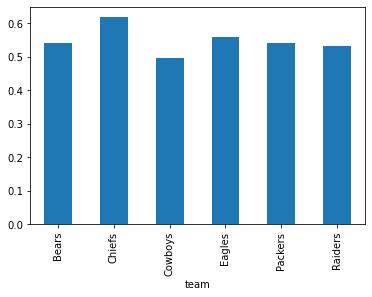

In [76]:
#group by teams
total_df.groupby('team')['sentiment'].mean().plot.bar()
total_df.groupby('team')['sentiment'].mean()

In [77]:
total_df.groupby(['team', 'source'])['sentiment'].mean()

team     source     
Bears    Twitter        0.492846
         Web Article    0.828571
Chiefs   Twitter        0.580247
         Web Article    0.829060
Cowboys  Twitter        0.466387
         Web Article    0.747126
Eagles   Twitter        0.540890
         Web Article    0.705263
Packers  Twitter        0.501370
         Web Article    0.830000
Raiders  Twitter        0.527273
         Web Article    0.593220
Name: sentiment, dtype: float64